# RUN PERFORMANCE PROJECT - Pau Sampietro

## Time Series Approach for predicting future 10 km races

In this file, we focus on some specific data, those flat moves whose lenghts are between 7 and 13 km. We want to know how the moving time for these moves is evolving with time. That could provides us a more accurate prediction for similar competitions

In [19]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
from rpdb import read_table, read_table_sql, export_table

#### Import moves from the database

In [2]:
Ssql = "SELECT * FROM moves WHERE athlete = 'P'"
moves = read_table_sql('moves', Ssql)
moves.head()

,index,move,start_time,distance,calories,athlete,accum_ascent,moving_time,pace,heart_rate,ascent_ratio
0,0,1,2017-07-02 09:46:40,4019.0,670.0,P,280.0,29.8,7.41,166.0,69.7
1,1,2,2017-07-02 10:32:23,4995.0,585.0,P,63.0,30.9,6.19,168.0,12.6
2,2,3,2017-07-19 17:49:13,4374.0,602.0,P,115.0,22.6,5.17,180.0,26.3
3,3,4,2017-07-20 17:56:41,3005.0,365.0,P,91.0,16.9,5.62,167.0,30.3
4,4,5,2017-07-24 16:17:34,6540.0,760.0,P,241.0,42.0,6.42,161.0,36.9


### 1. Filtering by distance, checking data interval and sorting moves

#### 1.1. We get only the flat moves within 7 and 13 km (10+/-3)

In [3]:
moves_ts = moves[(moves.distance >= 7000) & (moves.distance <= 13000) & (moves.ascent_ratio < 35)]
len(moves_ts)

51

#### 1.2. Preparing data: sort values, reindex, drop all but start_time & pace

In [4]:
moves_ts['start_time'].min(), moves_ts['start_time'].max()

(Timestamp('2017-08-11 17:23:17'), Timestamp('2019-01-24 08:13:43'))

* Droping all but useful time series columns, checking NaN values

In [5]:
cols = ['index', 'move','distance', 'calories', 'athlete', 'accum_ascent', 'moving_time', 'heart_rate', 'ascent_ratio']
moves_ts.drop(cols, axis=1, inplace=True)
moves_ts = moves_ts.sort_values('start_time')
moves_ts.isnull().sum()

start_time    0
pace          0
dtype: int64

In [6]:
moves_ts.set_index('start_time', inplace=True)

In [7]:
moves_ts.head()

,pace
start_time,
2017-08-11 17:23:17,5.75
2017-08-15 11:22:12,5.42
2017-08-18 17:53:14,5.94
2017-10-22 18:25:58,5.44
2017-10-24 18:11:50,5.41


* Interpolating pace for missing days

In [8]:
y = moves_ts['pace'].resample('D').mean().interpolate(method='linear')

### 2. Plotting Time series

#### 2.1. Plotting observed pae (min / km) during the time

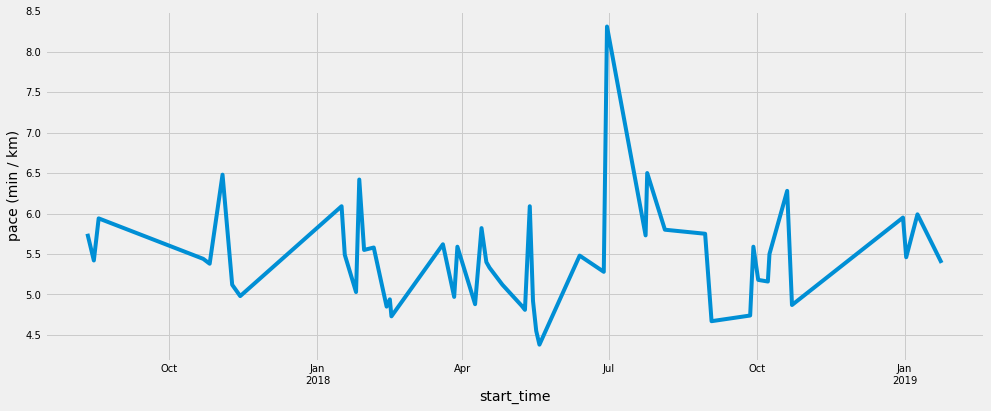

In [20]:
y.plot(figsize=(15, 6))
plt.ylabel('pace (min / km)')
plt.show()

#### 2.2. Decomposing into trend, seasonality and residual series

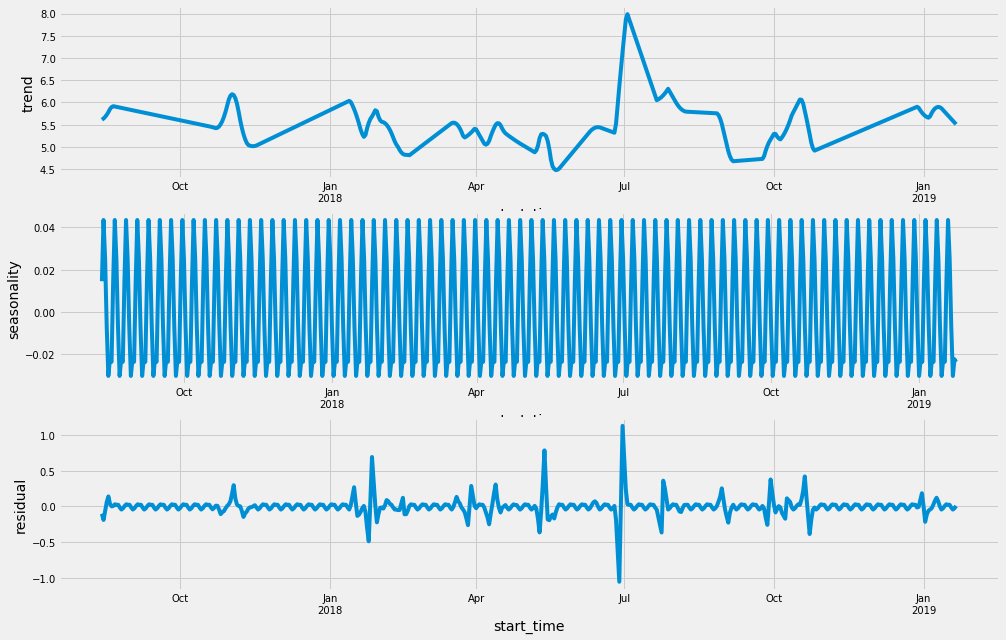

In [23]:
decomp = sm.tsa.seasonal_decompose(y, model='additive')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
decomp.trend.plot(ax=ax1)
ax1.set_ylabel('trend')
decomp.seasonal.plot(ax=ax2)
ax2.set_ylabel('seasonality')
decomp.resid.plot(ax=ax3)
ax3.set_ylabel('residual')
plt.show()

### 3. ARIMA Model and Pace Forecasting

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


#### 3.1. Looking for the best parameters and applying them to the model

Here we loop trought all combinations of parameters to find the minimum AIC score which means the model fits better

In [31]:
aics = []
par = []
parsea = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aics.append(results.aic)
            par.append(param)
            parsea.append(param_seasonal)
        except:
            continue

In [39]:
print(f'BEST AIC RESULT: {round(min(aics),1)} with: ARIMA{par[aics.index(min(aics))]}x{parsea[aics.index(min(aics))]}')

BEST AIC RESULT: -691.5 with: ARIMA(1, 1, 1)x(0, 0, 0, 12)


We can see as a minim AIC score -691, and now we take the parameters and seasonal parameters to apply to our model

#### 3.3. Fitting ARIMA model

In [40]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1072      0.026      4.132      0.000       0.056       0.158
ma.L1          0.4991      0.027     18.412      0.000       0.446       0.552
sigma2         0.0157      0.000     83.173      0.000       0.015       0.016


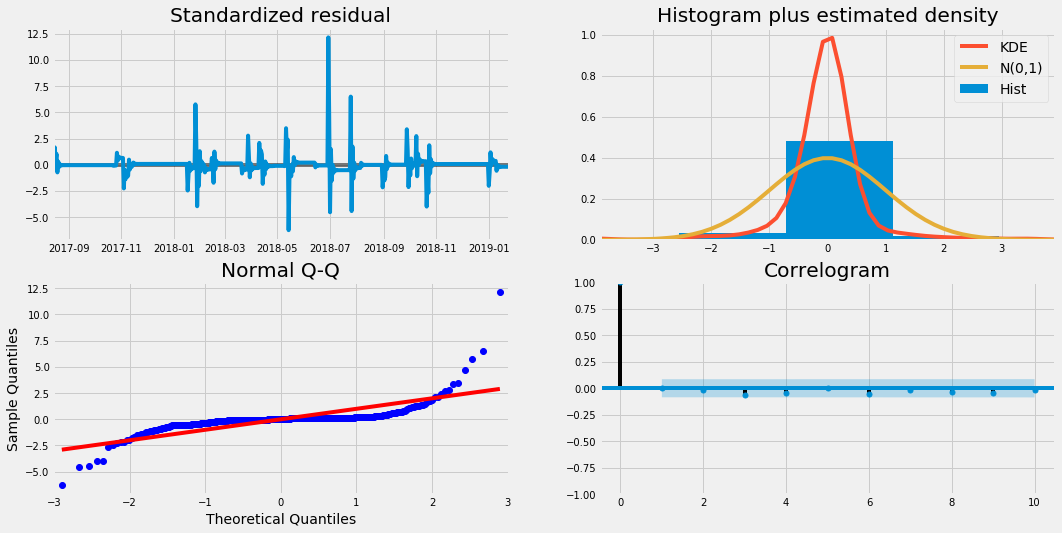

In [41]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()